In [159]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

import pickle

from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib.widgets import Slider
from matplotlib.colors import LogNorm

# Change Probability Model

In [233]:
feature_paths = [
    # "./result/test_pflc/manual-collect.csv",
    "./yj3-result/exp1_pflc_betterxb/manual-collect.csv",
    "./yj3-result/exp1_pflc_buildats/manual-collect.csv",
    "./yj3-result/exp1_pflc_itsttime/manual-collect.csv",
    "./yj3-result/exp1_pflc_rmlist/manual-collect.csv",
    "./yj3-result/exp1_pflc_storesfg/manual-collect.csv",
    "./yj3-result/exp1_pflc_tpsmay22/manual-collect.csv",
]
df = pd.concat([pd.read_csv(feature_path) for feature_path in feature_paths], ignore_index=True)
df

,Unnamed: 0,oid,pod_size,pod_max_change_prob,oid_count,oid_change_count,oid_change_prob,obj_type,obj_len,has_changed
0,0,140551958097712,2,0.0,0,0,0.0,str,8.0,True
1,1,140551957833072,2,0.0,0,0,0.0,str,12.0,True
2,2,140551958219088,2,0.0,0,0,0.0,module,NaN,True
3,3,140549179146592,2,0.0,0,0,0.0,function,NaN,True
4,4,140549178756400,2,0.0,0,0,0.0,str,10.0,True
...,...,...,...,...,...,...,...,...,...,...
62586,6218,139800133981488,2,0.0,1,1,1.0,bytes,20.0,False
62587,6219,139800169487936,2,0.0,0,0,0.0,dict,1.0,False
62588,6220,139800243995584,2,0.0,1,1,1.0,dict,0.0,False
62589,6221,139800172522368,2,0.0,0,0,0.0,dict,1.0,False


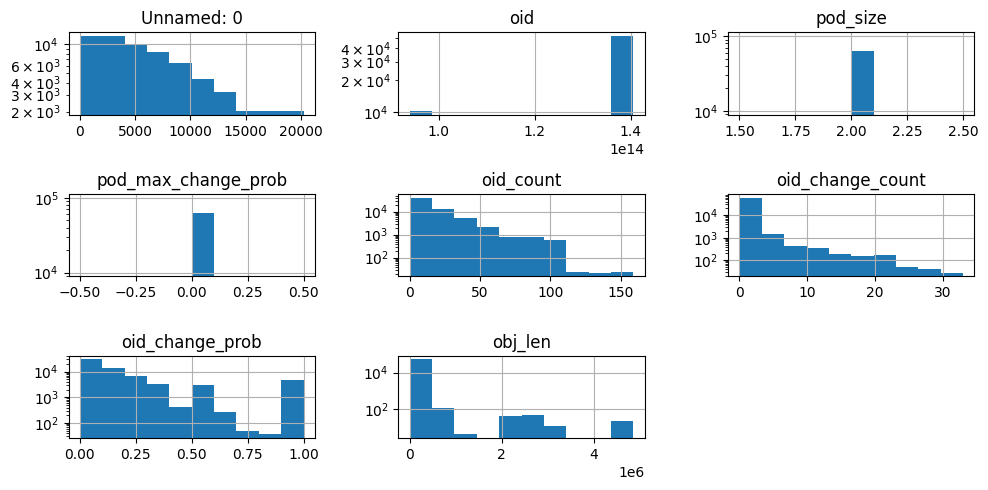

In [234]:
df.hist(figsize=(10, 5), log=True)
plt.tight_layout()
plt.show()

/var/folders/mq/s_mr5r6931595yybcg6bk32w0000gp/T/ipykernel_25784/2198673375.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


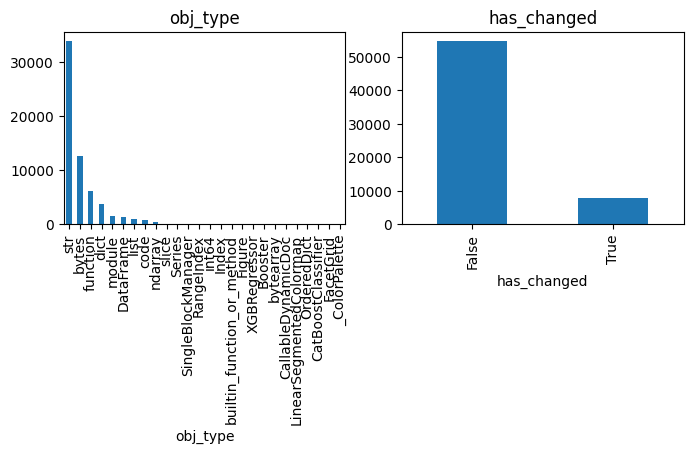

In [235]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 2.5))

df['obj_type'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('obj_type')

df['has_changed'].value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('has_changed')

plt.tight_layout()
plt.show()

In [236]:
X_df = df[[
    # "oid",
    "pod_size",
    "pod_max_change_prob",
    "oid_count",
    "oid_change_count",
    "oid_change_prob",
    # "obj_type",
    "obj_len",
]]
# X_df.loc[:,"obj_type"] = X_df["obj_type"].astype("category")
ys = df["has_changed"].astype("int").values
display(X_df)
display(ys)

,pod_size,pod_max_change_prob,oid_count,oid_change_count,oid_change_prob,obj_len
0,2,0.0,0,0,0.0,8.0
1,2,0.0,0,0,0.0,12.0
2,2,0.0,0,0,0.0,NaN
3,2,0.0,0,0,0.0,NaN
4,2,0.0,0,0,0.0,10.0
...,...,...,...,...,...,...
62586,2,0.0,1,1,1.0,20.0
62587,2,0.0,0,0,0.0,1.0
62588,2,0.0,1,1,1.0,0.0
62589,2,0.0,0,0,0.0,1.0


array([1, 1, 1, ..., 0, 0, 0])

In [237]:
X_df.isna().sum()

pod_size                  0
pod_max_change_prob       0
oid_count                 0
oid_change_count          0
oid_change_prob           0
obj_len                9050
dtype: int64

neg_pos_ratio=6.98341836734694


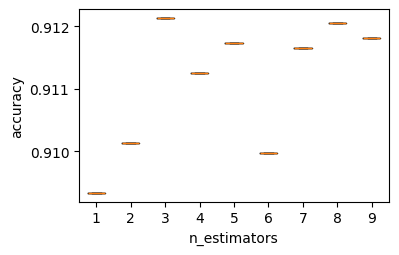

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X_df, ys, test_size=.2)
pos_fraction = y_train.sum() / len(y_train)
neg_fraction = 1 - pos_fraction
neg_pos_ratio = neg_fraction / pos_fraction
print(f"{neg_pos_ratio=}")

plt.figure(figsize=(4, 2.5))
all_accs = []
for n_estimators in xs:
    accs = []
    for _ in range(3):
        bst = XGBClassifier(enable_categorical=True, n_estimators=n_estimators, scale_pos_weight=neg_pos_ratio)
        bst.fit(X_train, y_train)
        y_test_pred = bst.predict(X_test)
        accs.append((y_test == y_test_pred).mean())
    all_accs.append(accs)
plt.boxplot(all_accs)
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
plt.show()

In [239]:
bst = XGBClassifier(enable_categorical=True, n_estimators=3, scale_pos_weight=neg_pos_ratio)
bst.fit(X_train, y_train)
y_test_pred = bst.predict(X_test)
y_test_pred_prob = bst.predict_proba(X_test)
print((y_test == y_test_pred).mean())

0.9121335569933701


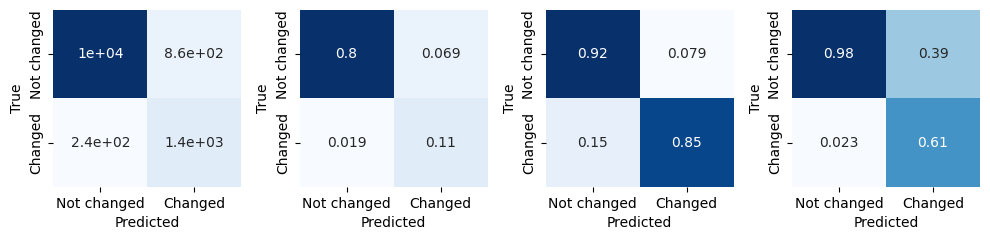

In [240]:
# Create confusion matrix
cms = [
    confusion_matrix(y_test, y_test_pred),
    confusion_matrix(y_test, y_test_pred, normalize='all'),
    confusion_matrix(y_test, y_test_pred, normalize='true'),
    confusion_matrix(y_test, y_test_pred, normalize='pred'),
]

# Plot confusion matrix
SZ = 2.5
fig, axs = plt.subplots(ncols=4, figsize=(4 * SZ, SZ))
for ax, cm in zip(axs, cms):
    sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, ax=ax,
                xticklabels=['Not changed', 'Changed'],
                yticklabels=['Not changed', 'Changed'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

plt.tight_layout()
plt.show()

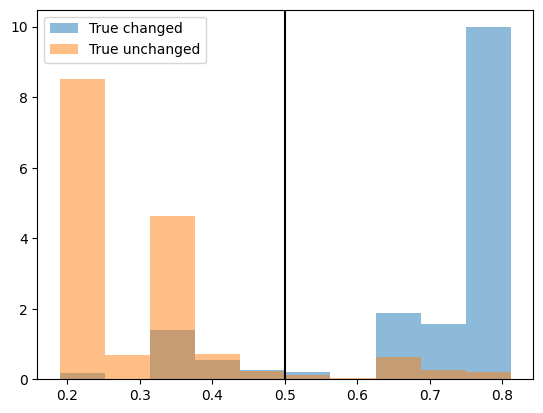

In [245]:
y_test_pred_prob_t = y_test_pred_prob[y_test == True][:, 1]
y_test_pred_prob_f = y_test_pred_prob[y_test == False][:, 1]
plt.hist(y_test_pred_prob_t, density=True, alpha = 0.5, label="True changed")
plt.hist(y_test_pred_prob_f, density=True, alpha = 0.5, label="True unchanged")
plt.axvline(0.5, color='k')
# plt.yscale("log")
plt.legend()
plt.show()

0


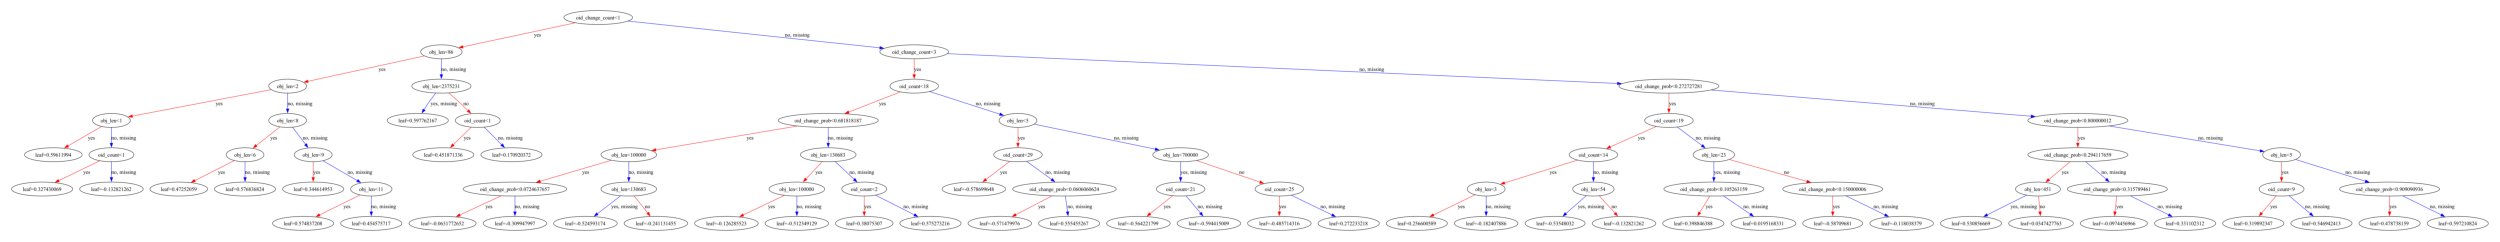

1


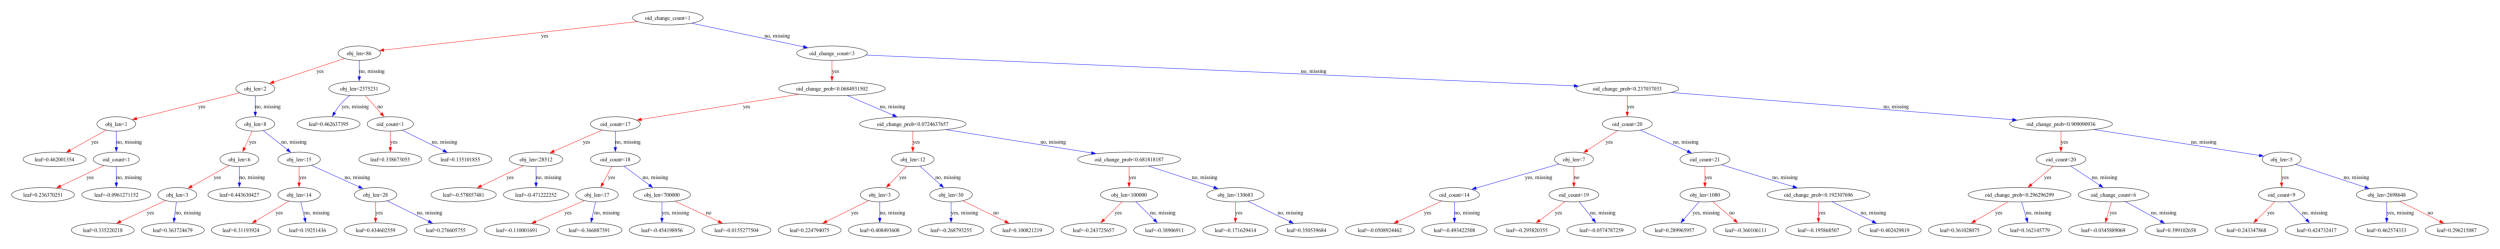

2


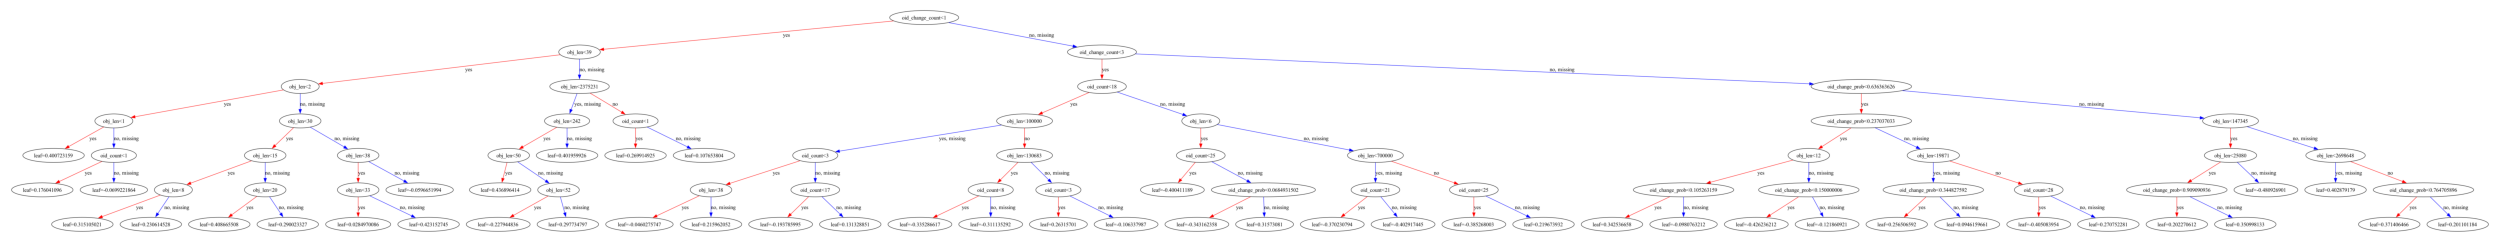

In [252]:
RS, SZ = 1.6, 20
for idx in range(len(bst.get_booster().get_dump())):
    print(idx)
    fig, ax = plt.subplots(figsize=(RS * SZ, SZ))
    xgb.plot_tree(bst, num_trees=idx, ax=ax)
    plt.show()

# Rate of Change Model

In [345]:
feature_paths = [
    "./yj7full-result/exp1_prcc_betterxb/roc-collect/feature.csv",
    "./yj7full-result/exp1_prcc_buildats/roc-collect/feature.csv",
    "./yj7full-result/exp1_prcc_itsttime/roc-collect/feature.csv",
    "./yj7full-result/exp1_prcc_rmlist/roc-collect/feature.csv",
    "./yj7full-result/exp1_prcc_storesfg/roc-collect/feature.csv",
    "./yj7full-result/exp1_prcc_tpsmay22/roc-collect/feature.csv",
]
dff = pd.concat([pd.read_csv(feature_path) for feature_path in feature_paths], ignore_index=True)
dff

,Unnamed: 0,oid,global,type,type_global,type_pickler_dispatch,type_subclass_type,type_module,type_module_global,has_reduce_ex,has_reduce,size,len,len_dict,len_slots
0,0,140374368399152,False,str,False,False,False,builtins,True,True,True,57,8.0,NaN,NaN
1,1,140371520087728,False,PodId,False,False,False,pod.common,False,True,True,48,NaN,2.0,NaN
2,2,94040335215008,False,type,False,False,True,builtins,True,True,True,1072,NaN,17.0,NaN
3,3,140374367065328,False,str,False,False,False,builtins,True,True,True,59,10.0,NaN,NaN
4,4,140371623198896,False,str,False,False,False,builtins,True,True,True,54,5.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496951,1595592,139657237202880,False,dict,False,False,False,builtins,True,True,True,232,1.0,NaN,NaN
2496952,1595593,139657237146160,False,str,False,False,False,builtins,True,True,True,51,2.0,NaN,NaN
2496953,1595594,139657237135472,False,str,False,False,False,builtins,True,True,True,52,3.0,NaN,NaN
2496954,1595595,139657237215280,False,str,False,False,False,builtins,True,True,True,52,3.0,NaN,NaN


In [346]:
change_paths = [
    "./yj7full-result/exp1_prcc_betterxb/roc-collect/change.csv",
    "./yj7full-result/exp1_prcc_buildats/roc-collect/change.csv",
    "./yj7full-result/exp1_prcc_itsttime/roc-collect/change.csv",
    "./yj7full-result/exp1_prcc_rmlist/roc-collect/change.csv",
    "./yj7full-result/exp1_prcc_storesfg/roc-collect/change.csv",
    "./yj7full-result/exp1_prcc_tpsmay22/roc-collect/change.csv",
]
dfc = pd.concat([pd.read_csv(change_path) for change_path in change_paths], ignore_index=True)
dfc

,Unnamed: 0,oid,nth,has_changed
0,0,140374368399152,0,True
1,1,140371520087728,0,True
2,2,94040335215008,0,True
3,3,140374367065328,0,True
4,4,140371623198896,0,True
...,...,...,...,...
69582421,52604758,139657237202880,0,False
69582422,52604759,139657237146160,0,False
69582423,52604760,139657237135472,0,False
69582424,52604761,139657237215280,0,False


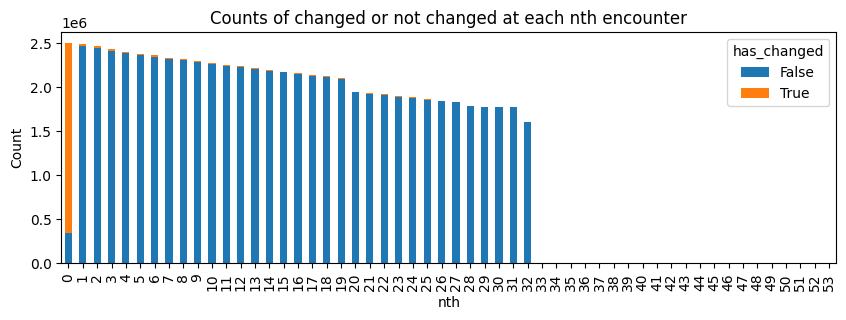

In [347]:
grouped = dfc.groupby(['nth', 'has_changed']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(10, 3))
grouped.plot(kind='bar', stacked=True, ax=ax)
plt.xlabel('nth')
plt.ylabel('Count')
plt.title('Counts of changed or not changed at each nth encounter')
plt.legend(title='has_changed', labels=['False', 'True'])
plt.show()

In [348]:
dfc_agg = dfc.groupby('oid').agg({'has_changed': ['sum', 'count']})
dfc_agg.columns = ['num_changes', 'num_seen']
dfc_agg.reset_index(inplace=True)
dfc_agg

,oid,num_changes,num_seen
0,93855332171936,1,42
1,93855332172352,1,17
2,93855332173440,1,17
3,93855332208768,1,17
4,93855332221024,1,17
...,...,...,...
2496951,140375195673968,1,10
2496952,140375195938608,1,10
2496953,140375196087920,1,10
2496954,140375196099440,1,10


In [349]:
IMMUTABLE_TYPES = [
    'str',
    'bytes',
    'int',
    'float',
    'complex',
    'bool',
    'tuple',
    'frozenset',
    'NoneType',
    'type',
]

df = pd.merge(dff, dfc_agg, on='oid')
df['immutable_type'] = df['type'].isin(IMMUTABLE_TYPES)
df = df[df['immutable_type'] == False]
df

,Unnamed: 0,oid,global,type,type_global,type_pickler_dispatch,type_subclass_type,type_module,type_module_global,has_reduce_ex,has_reduce,size,len,len_dict,len_slots,num_changes,num_seen,immutable_type
1,1,140371520087728,False,PodId,False,False,False,pod.common,False,True,True,48,NaN,2.0,NaN,1,34,False
6,6,140371520087632,False,PodId,False,False,False,pod.common,False,True,True,48,NaN,2.0,NaN,1,34,False
8,8,140371520087872,False,PodId,False,False,False,pod.common,False,True,True,48,NaN,2.0,NaN,1,34,False
10,10,140371520088016,False,PodId,False,False,False,pod.common,False,True,True,48,NaN,2.0,NaN,1,34,False
12,12,140371520088112,False,PodId,False,False,False,pod.common,False,True,True,48,NaN,2.0,NaN,1,34,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496946,1595587,139657237369088,False,dict,False,False,False,builtins,True,True,True,232,2.0,NaN,NaN,0,1,False
2496947,1595588,139663641076224,False,list,False,False,False,builtins,True,True,True,384,41.0,NaN,NaN,0,1,False
2496948,1595589,139657237097408,False,dict,False,False,False,builtins,True,True,True,232,1.0,NaN,NaN,0,1,False
2496950,1595591,139657237099648,False,dict,False,False,False,builtins,True,True,True,232,1.0,NaN,NaN,0,1,False


In [386]:
X_df = df[[
    # 'oid',
    # 'global',  # low gain
    # 'type',
    # 'type_global',  # hard to extract
    # 'type_pickler_dispatch',  # low gain
    # 'type_subclass_type',  # low gain
    # 'type_module',
    # 'type_module_global',  # hard to extract
    # 'immutable_type',
    # 'has_reduce_ex',  # low gain
    # 'has_reduce',  # low gain
    'size',
    'len',
    'len_dict',
    # 'len_slots',  # low gain
    # 'num_changes',
    # 'num_seen'
]]
# X_df.loc[:,"obj_type"] = X_df["obj_type"].astype("category")
ys = np.clip(df["num_changes"].astype("float").values - 1, a_min=0, a_max=float('inf')) / df["num_seen"].astype("float").values
display(X_df)
display(ys)

,size,len,len_dict
1,48,NaN,2.0
6,48,NaN,2.0
8,48,NaN,2.0
10,48,NaN,2.0
12,48,NaN,2.0
...,...,...,...
2496946,232,2.0,NaN
2496947,384,41.0,NaN
2496948,232,1.0,NaN
2496950,232,1.0,NaN


array([0., 0., 0., ..., 0., 0., 0.])

Text(0.5, 0, 'Rate of change')

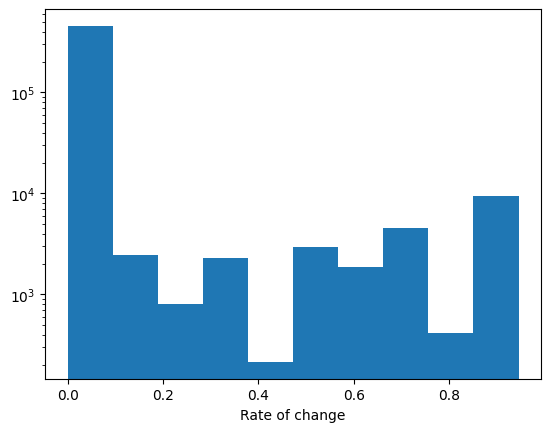

In [387]:
plt.hist(ys)
plt.yscale("log")
plt.xlabel("Rate of change")

In [388]:
X_df.isna().sum()

size             0
len          24679
len_dict    453575
dtype: int64

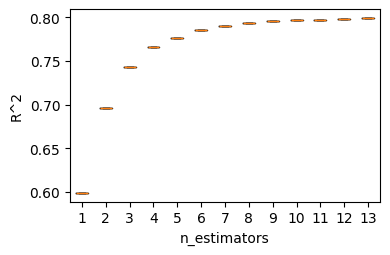

In [389]:
X_train, X_test, y_train, y_test = train_test_split(X_df, ys, test_size=.2)

plt.figure(figsize=(4, 2.5))
all_accs = []
for n_estimators in range(2, 15):
    accs = []
    for _ in range(1):
        bst = XGBRegressor(n_estimators=n_estimators)
        bst.fit(X_train, y_train)
        accs.append(bst.score(X_test, y_test))
    all_accs.append(accs)
plt.boxplot(all_accs)
plt.xlabel("n_estimators")
plt.ylabel("R^2")
plt.show()

In [390]:
bst = XGBRegressor(n_estimators=9).fit(X_train, y_train)
y_test_pred = bst.predict(X_test)
print("Train R^2:", bst.score(X_train, y_train))
print("Test R^2:", bst.score(X_test, y_test))

Train R^2: 0.7942016443418828
Test R^2: 0.7938580025037956


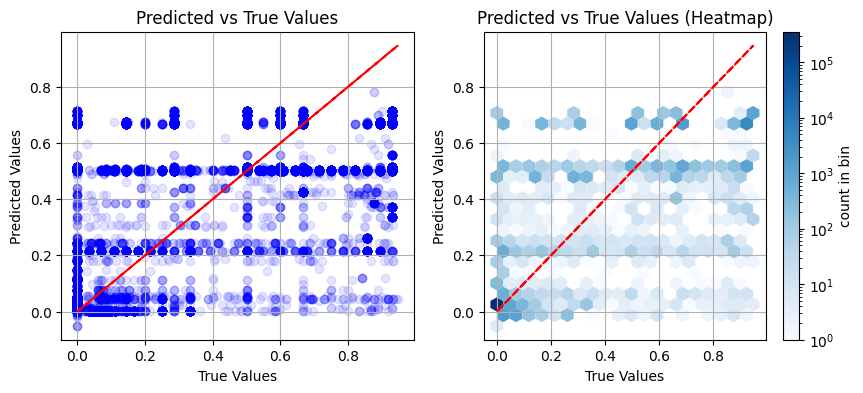

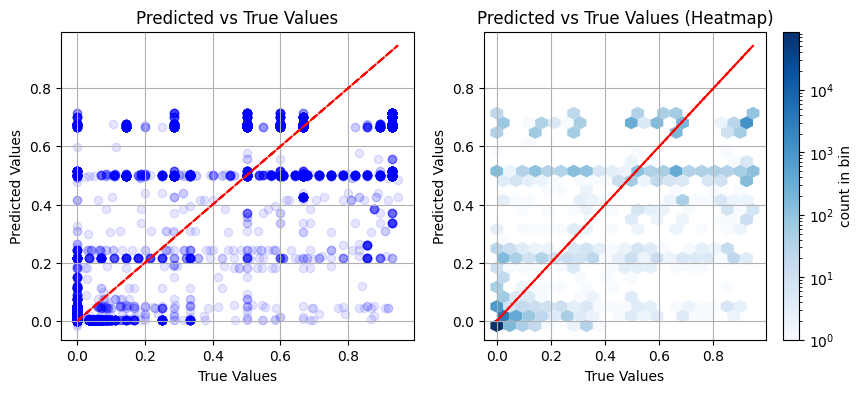

In [391]:
def plot_check(X_test, y_test, bst):
    y_test_pred = bst.predict(X_test)

    fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
    
    axs[0].scatter(y_test, y_test_pred, color='blue', alpha=0.1)
    axs[0].plot(y_test, y_test, color='red', linestyle='--')  # Plot y=x line for reference
    axs[0].set_title('Predicted vs True Values')
    axs[0].set_xlabel('True Values')
    axs[0].set_ylabel('Predicted Values')
    axs[0].grid(True)
    
    hb = axs[1].hexbin(y_test, y_test_pred, gridsize=20, cmap='Blues', edgecolors='none', norm=LogNorm())
    axs[1].plot(y_test, y_test, color='red', linestyle='--')  # Plot y=x line for reference
    plt.colorbar(hb, ax=axs[1], label='count in bin')
    axs[1].set_title('Predicted vs True Values (Heatmap)')
    axs[1].set_xlabel('True Values')
    axs[1].set_ylabel('Predicted Values')
    axs[1].grid(True)
    
    plt.show()

plot_check(X_train, y_train, bst)
plot_check(X_test, y_test, bst)

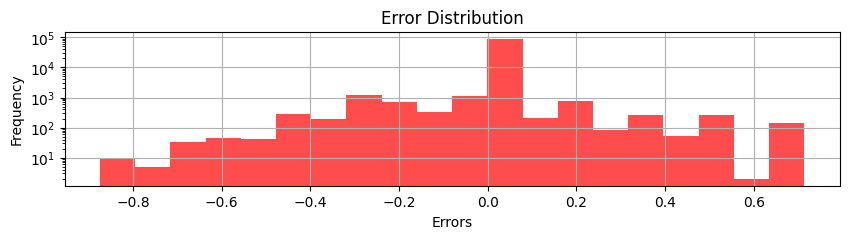

In [392]:
errors = y_test_pred - y_test

plt.figure(figsize=(10, 2))
plt.hist(errors, bins=20, color='red', alpha=0.7)
plt.title('Error Distribution')
plt.xlabel('Errors')
plt.ylabel('Frequency')
plt.yscale('log')
plt.grid(True)
plt.show()

In [393]:
dfe = X_test.copy()
dfe["mse"] = (y_test_pred - y_test) ** 2
dfe.sort_values("mse")

,size,len,len_dict,mse
338568,48,NaN,7.0,1.862536e-08
333637,48,NaN,7.0,1.862536e-08
339877,48,NaN,7.0,1.862536e-08
338418,48,NaN,7.0,1.862536e-08
335838,48,NaN,7.0,1.862536e-08
...,...,...,...,...
643568,48,NaN,2.0,7.382440e-01
184494,96,4.0,NaN,7.394341e-01
515722,96,0.0,NaN,7.476018e-01
363581,96,0.0,NaN,7.646938e-01


In [394]:
bst.get_booster().get_score(importance_type='gain')

{'size': 22.08043670654297,
 'len': 16.110158920288086,
 'len_dict': 100.53646850585938}

In [395]:
bst.get_booster().feature_names

['size', 'len', 'len_dict']

0


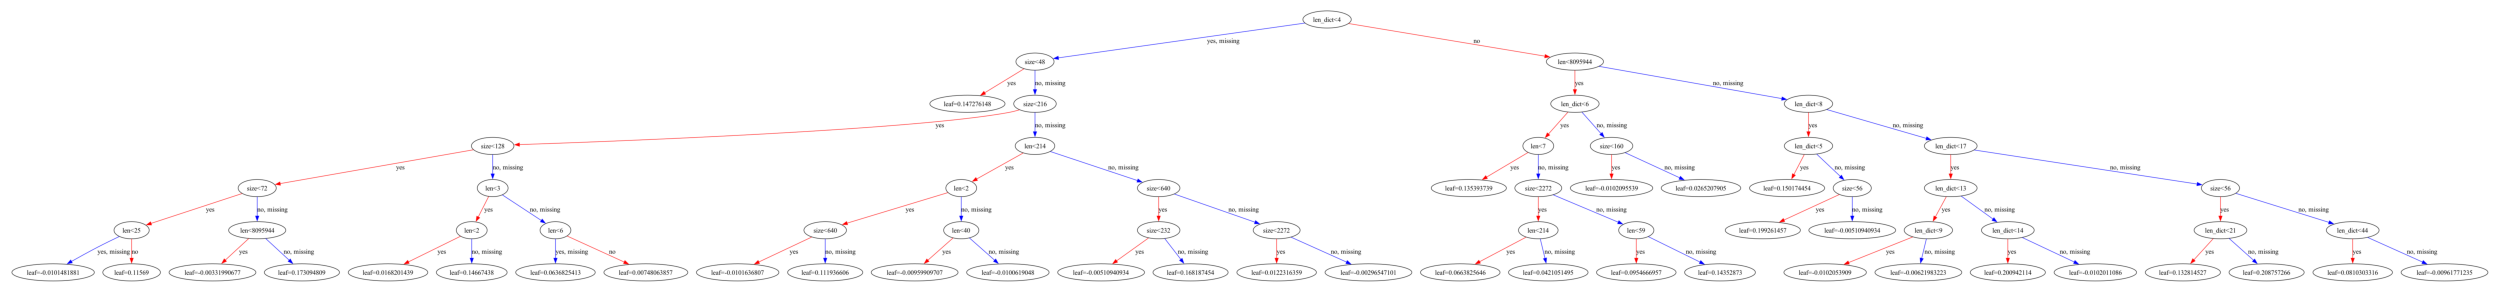

1


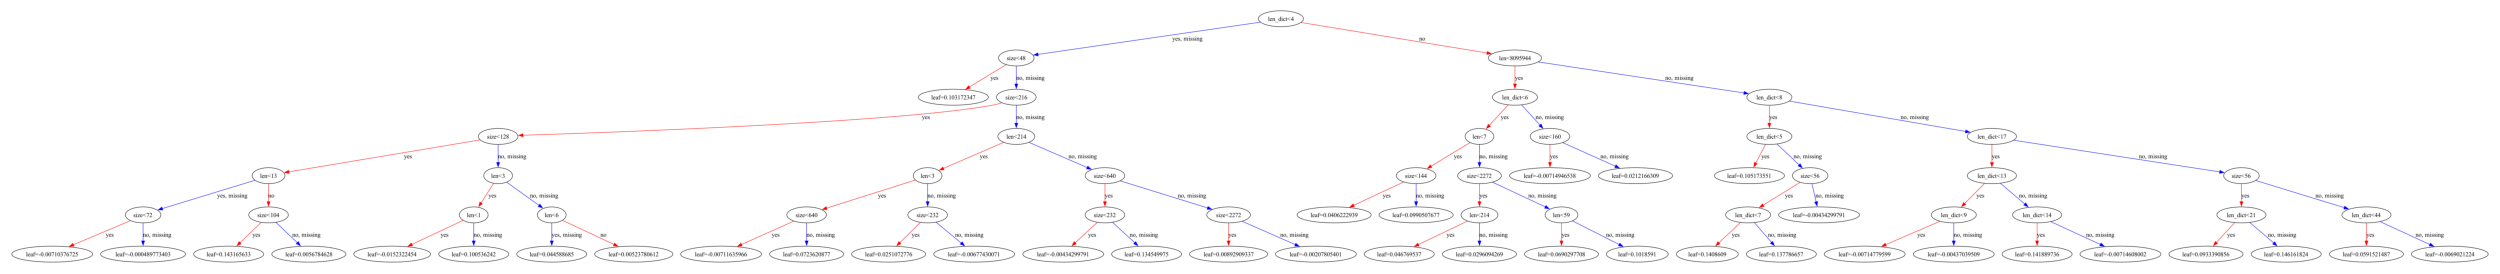

2


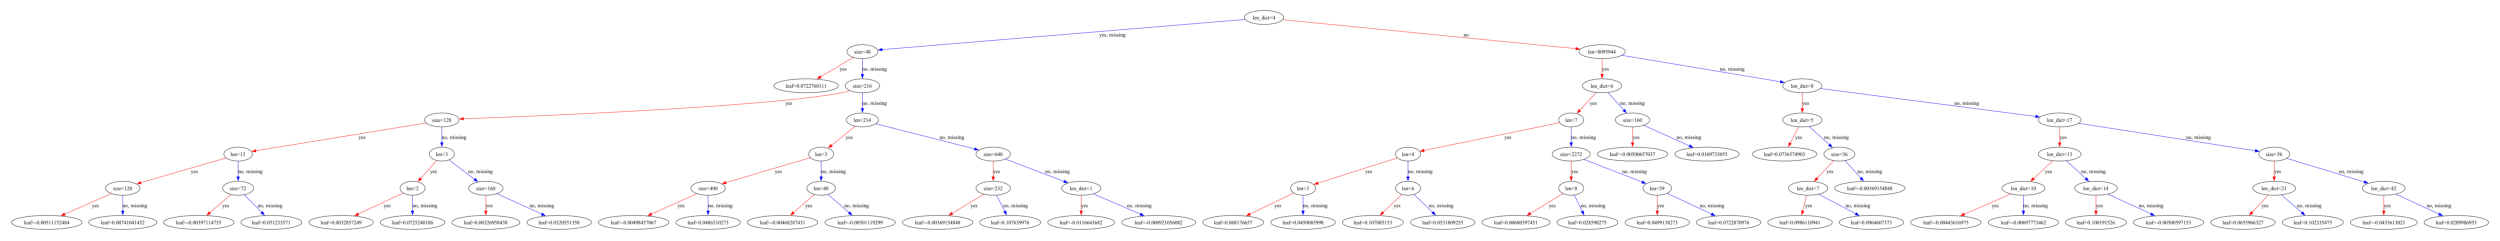

3


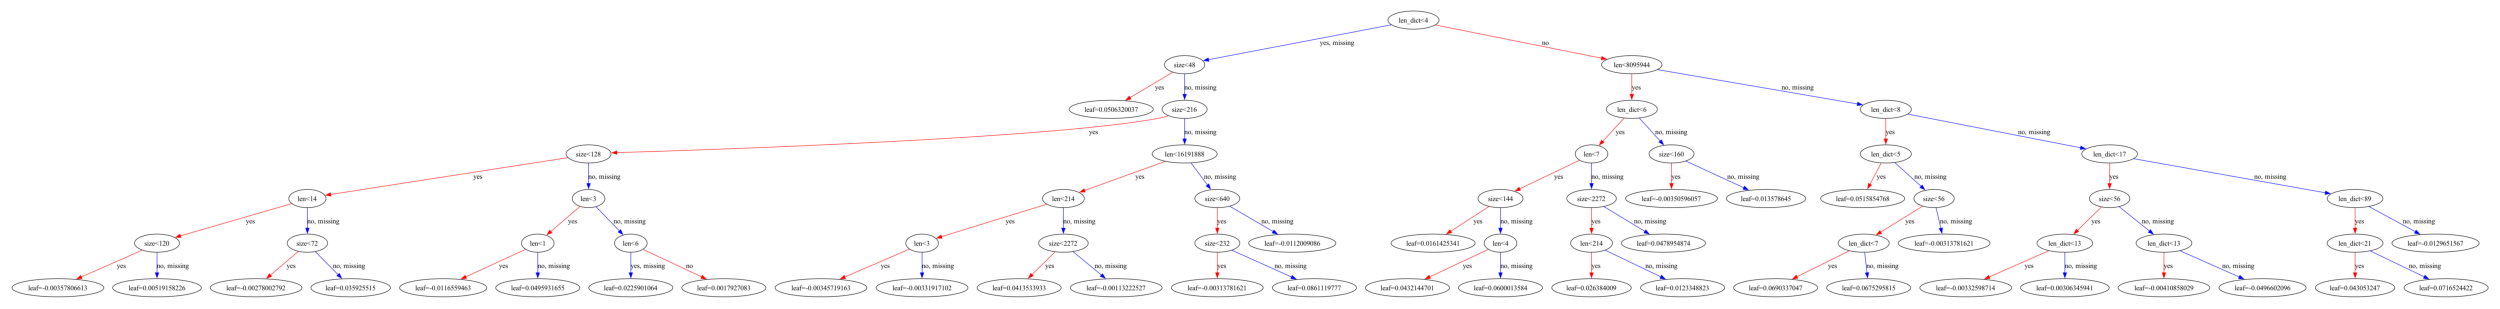

4


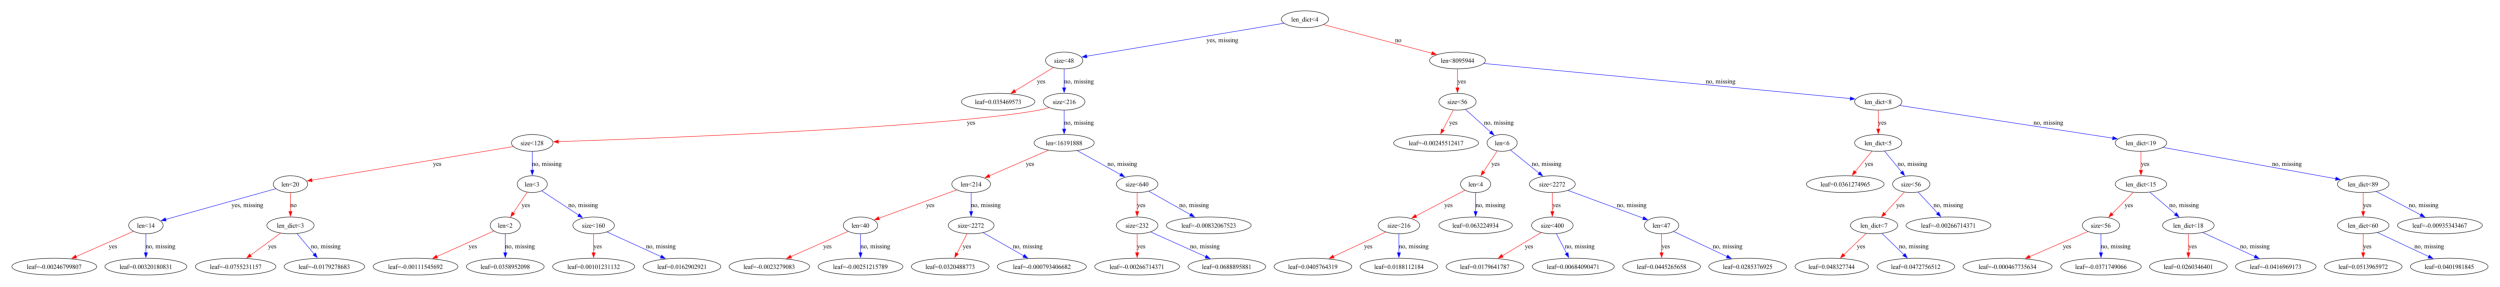

5


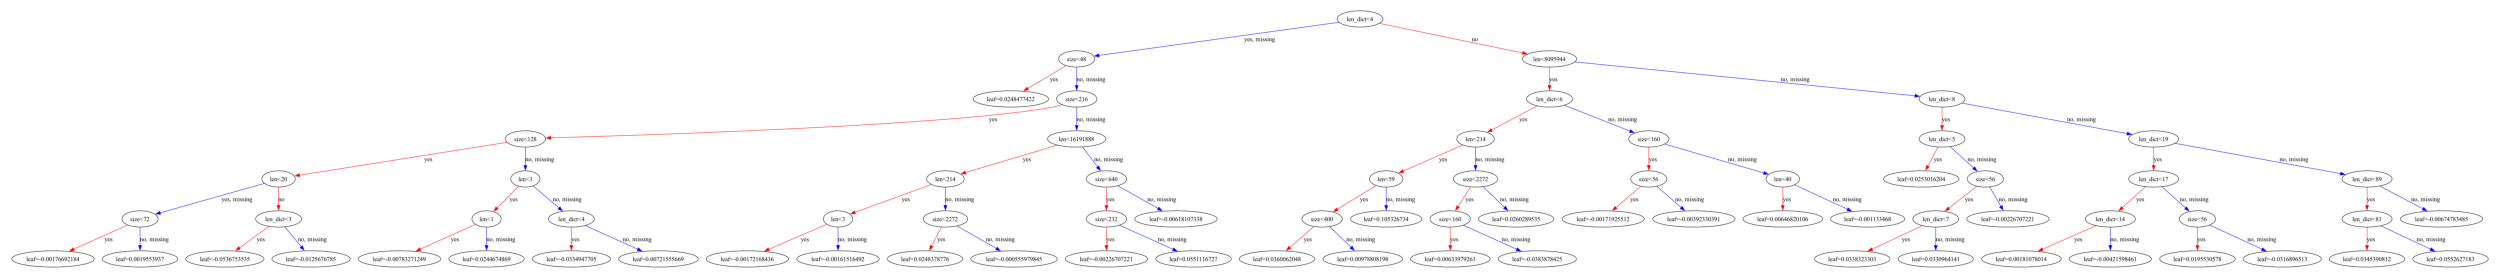

6


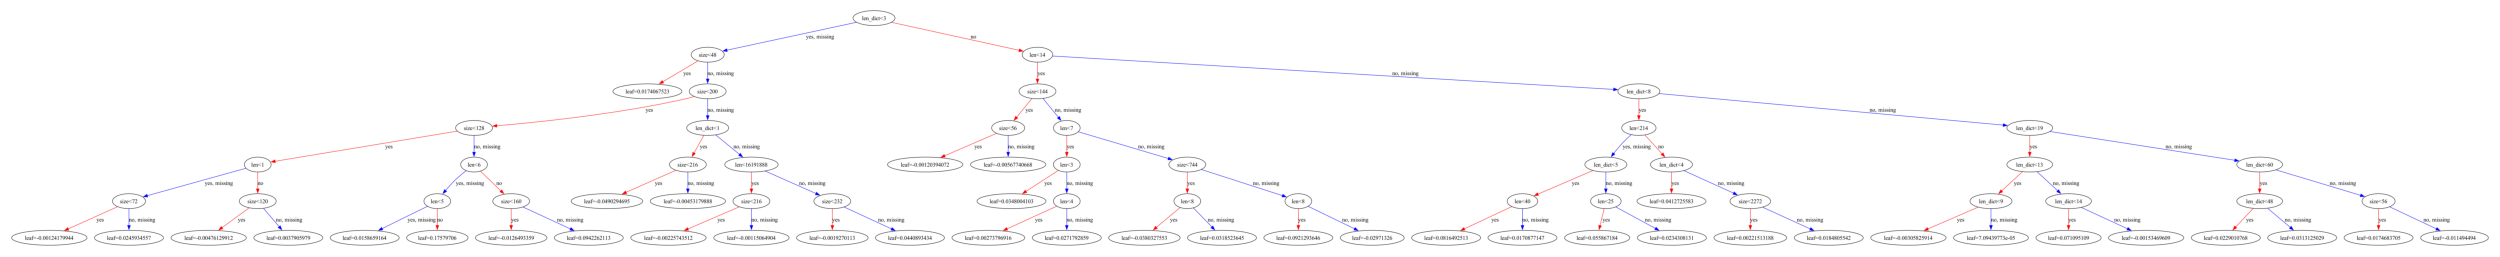

7


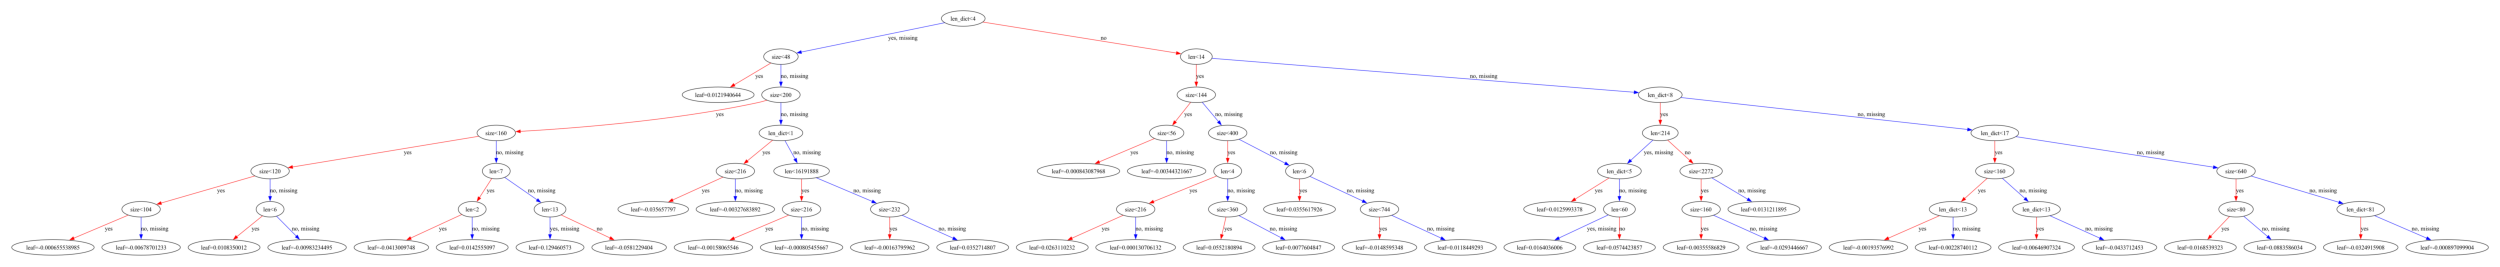

8


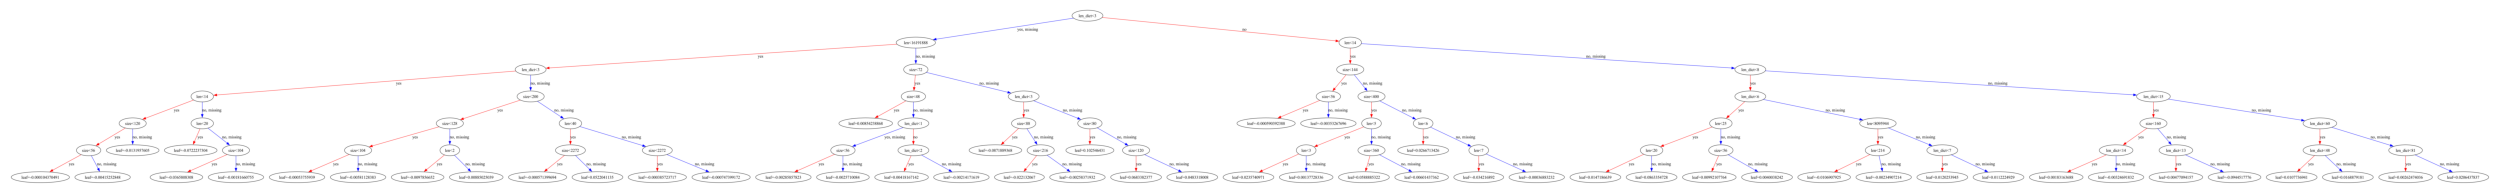

In [396]:
RS, SZ = 1.6, 20
for idx in range(len(bst.get_booster().get_dump())):
    print(idx)
    fig, ax = plt.subplots(figsize=(RS * SZ, SZ))
    xgb.plot_tree(bst, num_trees=idx, ax=ax)
    plt.show()

In [397]:
with open("models/roc_model.pkl", "wb") as f:
    pickle.dump(bst, f)

In [398]:
bst.predict([[10, 10, 10]])[0]

0.0013793793